In [1]:

import tensorflow as tf
from tensorflow.keras import layers, models, applications, Input, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

/Users/admin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_GENDER_CLASSES = 2
NUM_AGE_CLASSES = 4

In [6]:
import os
from PIL import Image
from IPython.display import display

folder_path = '/Users/admin/Downloads/Final_Dataset'  # Change this to your folder path

# Check if the folder exists
if not os.path.exists(folder_path):
    print(f"Error: The folder '{folder_path}' does not exist.")
else:
    # List all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    
    if not image_files:
        print("No image files found in the specified folder.")
    else:
        # Load all images
        images = []
        for file in image_files:
            img_path = os.path.join(folder_path, file)
            try:
                img = Image.open(img_path)
                images.append(img)
            except Exception as e:
                print(f"Error loading image {file}: {e}")
        
        # Display the first image as an example
        if images:
            display(images[0])
        else:
            print("No valid images could be loaded.")

No image files found in the specified folder.


In [7]:
import os
from collections import defaultdict

def count_images_in_directory(root_dir):
    count_dict = defaultdict(lambda: defaultdict(int))  # {split: {label: count}}

    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(root_dir, split)
        for label in os.listdir(split_dir):
            label_dir = os.path.join(split_dir, label)
            if os.path.isdir(label_dir):
                num_images = len([
                    f for f in os.listdir(label_dir)
                    if os.path.isfile(os.path.join(label_dir, f)) and f.endswith(('.jpg', '.png'))
                ])
                count_dict[split][label] = num_images
    return count_dict

dataset_path = "/Users/admin/Downloads/Final_Dataset"
image_counts = count_images_in_directory(dataset_path)


import pandas as pd
df = pd.DataFrame(image_counts).fillna(0).astype(int)
df['Total'] = df.sum(axis=1)
df.loc['Total'] = df.sum()
df

,train,val,test,Total
female_teen,844,105,106,1055
female_child,806,101,102,1009
female_adult,846,106,106,1058
male_child,800,100,101,1001
male_elderly,805,101,102,1008
female_elderly,813,102,102,1017
male_adult,823,104,105,1032
male_teen,848,106,106,1060
Total,6585,825,830,8240


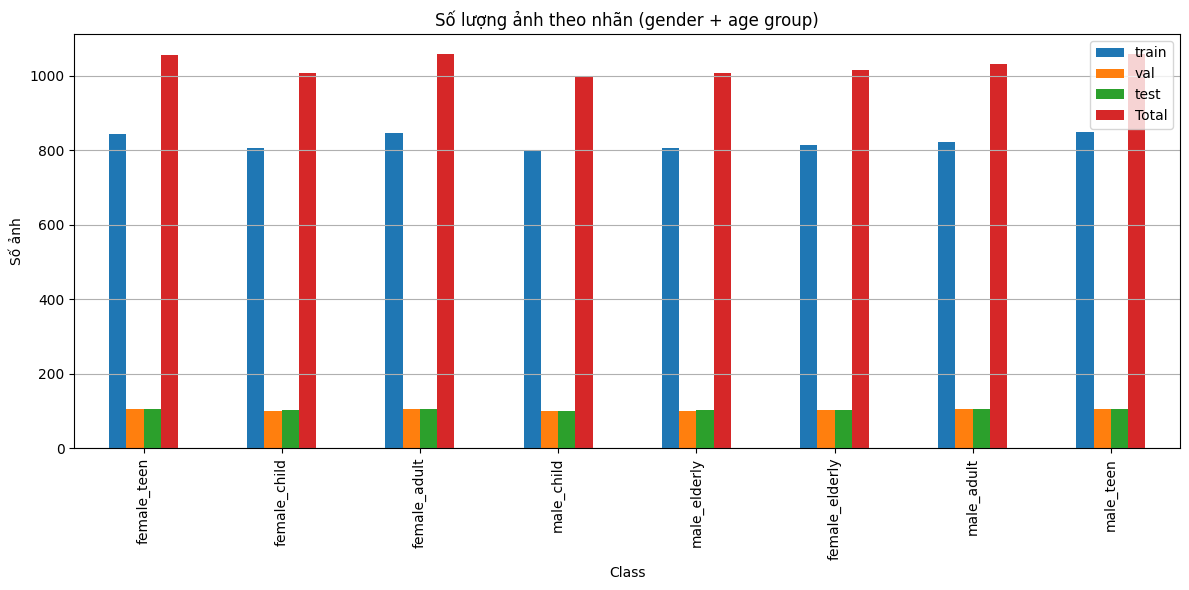

In [8]:
df_no_total = df.drop(index='Total')
df_no_total.plot(kind='bar', figsize=(12,6))
plt.title("Số lượng ảnh theo nhãn (gender + age group)")
plt.xlabel("Class")
plt.ylabel("Số ảnh")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [9]:
df_gender = df_no_total.copy()
df_gender['gender'] = df_gender.index.map(lambda x: x.split('_')[0])
df_gender['age_group'] = df_gender.index.map(lambda x: x.split('_')[1])

# Tổng theo giới tính
gender_summary = df_gender.groupby('gender')[['train', 'val', 'test', 'Total']].sum()

# Tổng theo nhóm tuổi
age_summary = df_gender.groupby('age_group')[['train', 'val', 'test', 'Total']].sum()

display(gender_summary)
display(age_summary)

,train,val,test,Total
gender,,,,
female,3309,414,416,4139
male,3276,411,414,4101


,train,val,test,Total
age_group,,,,
adult,1669,210,211,2090
child,1606,201,203,2010
elderly,1618,203,204,2025
teen,1692,211,212,2115


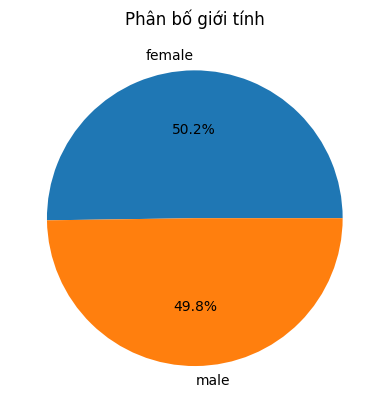

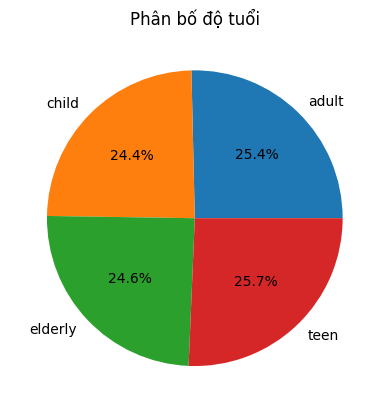

In [10]:
gender_summary['Total'].plot(kind='pie', autopct='%1.1f%%', title='Phân bố giới tính', ylabel='')
plt.show()

age_summary['Total'].plot(kind='pie', autopct='%1.1f%%', title='Phân bố độ tuổi', ylabel='')
plt.show()

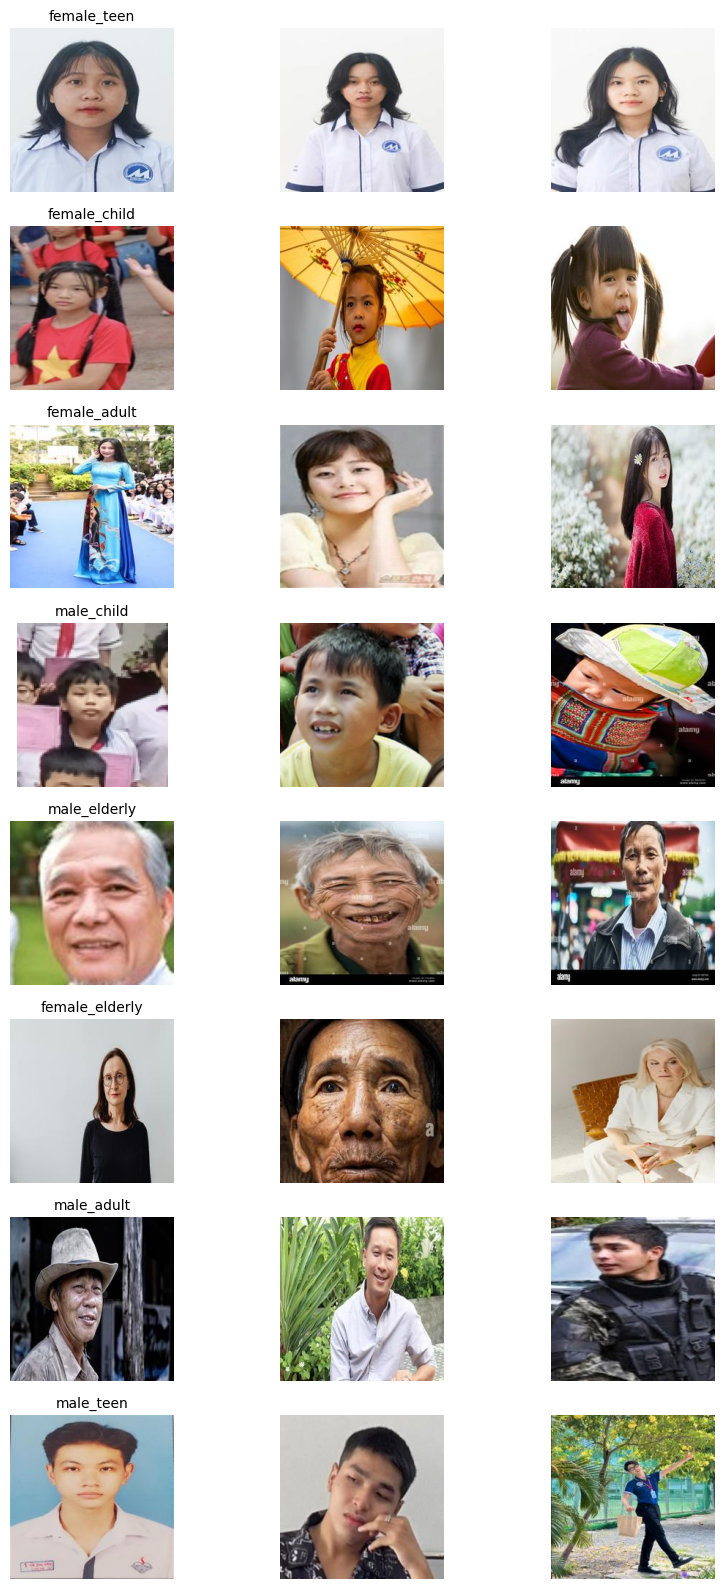

In [11]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_sample_images(dataset_dir, split='train', num_per_class=3):
    fig, axes = plt.subplots(len(df_no_total), num_per_class, figsize=(num_per_class*3, len(df_no_total)*2))
    for row_idx, label in enumerate(df_no_total.index):
        label_dir = os.path.join(dataset_dir, split, label)
        sample_imgs = random.sample(os.listdir(label_dir), num_per_class)
        for col_idx, img_name in enumerate(sample_imgs):
            img_path = os.path.join(label_dir, img_name)
            img = mpimg.imread(img_path)
            axes[row_idx][col_idx].imshow(img)
            axes[row_idx][col_idx].axis('off')
            if col_idx == 0:
                axes[row_idx][col_idx].set_title(label, fontsize=10)
    plt.tight_layout()
    plt.show()

show_sample_images(dataset_path, split='train', num_per_class=3)

Bắt đầu traning

In [12]:
DATASET_DIR = "/Users/admin/Downloads/Final_Dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = train_ds.class_names
class_names_tensor = tf.constant(class_names, dtype=tf.string)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 6616 files belonging to 8 classes.
Found 826 files belonging to 8 classes.
Found 832 files belonging to 8 classes.


In [13]:
LOSS = {
    "gender_output" : "binary_crossentropy",
    "age_output"    : "categorical_crossentropy"
}
LOSS_W = {"gender_output":1.0, "age_output":0.5}
METRICS = {"gender_output":"accuracy", "age_output":"accuracy"}

NUM_AGE_CLASSES   = 4
NUM_GENDER_CLASSES= 2


In [15]:
def build_multi_task_model(backbone_fn, lr=1e-4, freeze=0.8):
    base = backbone_fn(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
    # Freeze bottom layers
    for l in base.layers[:int(len(base.layers)*freeze)]:
        l.trainable = False

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    gender = layers.Dense(NUM_GENDER_CLASSES, activation="softmax", name="gender_output")(x)
    age    = layers.Dense(NUM_AGE_CLASSES,    activation="softmax", name="age_output")(x)

    model = models.Model(base.input, [gender, age])
    model.compile(optimizer=keras.optimizers.Adam(lr),
                  loss=LOSS, loss_weights=LOSS_W, metrics=METRICS)
    return model

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)


=== ResNet50 ===
Epoch 1/30
207/207 - 507s - 2s/step - age_output_accuracy: 0.7121 - age_output_loss: 0.7918 - gender_output_accuracy: 0.8210 - gender_output_loss: 0.4207 - loss: 0.8167 - val_age_output_accuracy: 0.8196 - val_age_output_loss: 0.5428 - val_gender_output_accuracy: 0.8971 - val_gender_output_loss: 0.2583 - val_loss: 0.5292 - learning_rate: 1.0000e-04
Epoch 2/30
207/207 - 375s - 2s/step - age_output_accuracy: 0.8619 - age_output_loss: 0.3845 - gender_output_accuracy: 0.9350 - gender_output_loss: 0.1799 - loss: 0.3717 - val_age_output_accuracy: 0.8329 - val_age_output_loss: 0.5793 - val_gender_output_accuracy: 0.8269 - val_gender_output_loss: 0.6923 - val_loss: 0.9813 - learning_rate: 1.0000e-04
Epoch 3/30
207/207 - 412s - 2s/step - age_output_accuracy: 0.9222 - age_output_loss: 0.2146 - gender_output_accuracy: 0.9755 - gender_output_loss: 0.0794 - loss: 0.1865 - val_age_output_accuracy: 0.8245 - val_age_output_loss: 0.6759 - val_gender_output_accuracy: 0.9068 - val_gender

,Backbone,Best Gender Acc,Best Age Acc,Latency ms
0,ResNet50,0.9237,0.8826,183.5524
1,ResNet101,0.9334,0.8753,230.9546
2,EfficientNetB0,0.9298,0.8705,376.2705
3,InceptionV3,0.7663,0.6671,430.5576


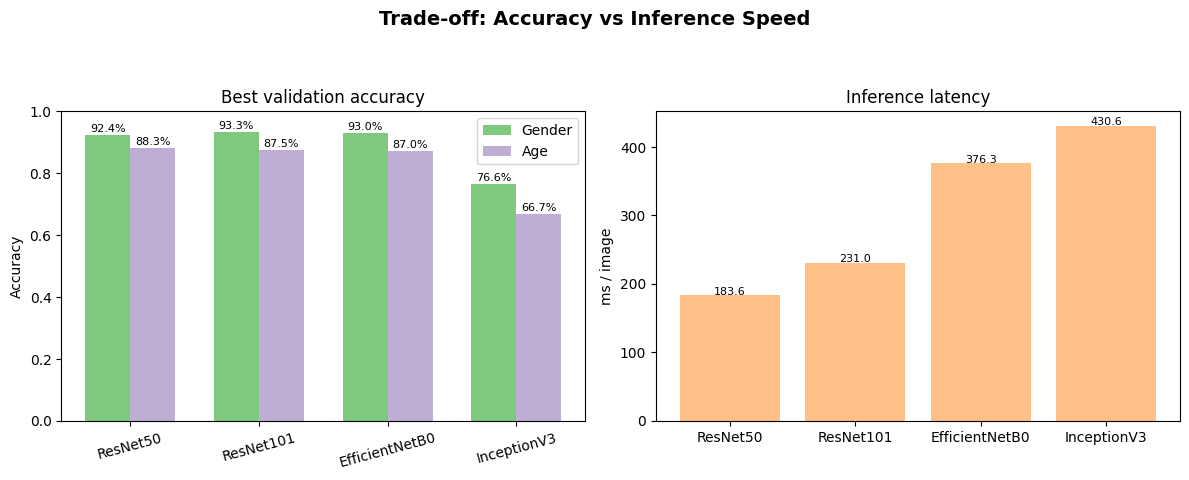

In [45]:
import tensorflow as tf, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display   # <-- added

# 1) candidate backbones ---------------------------------------------------
BACKBONES = {
    "ResNet50"       : tf.keras.applications.ResNet50,
    "ResNet101"      : tf.keras.applications.ResNet101,
    "EfficientNetB0" : tf.keras.applications.EfficientNetB0,
    "InceptionV3"    : tf.keras.applications.InceptionV3,
}

results = []
dummy = tf.random.normal([1, 224, 224, 3])

from pathlib import Path
Path("models").mkdir(parents=True, exist_ok=True) 

for name, Arch in BACKBONES.items():
    print(f"\n=== {name} ===")
    model = build_multi_task_model(Arch)        # 👈  không thêm (weights=…)
    hist  = model.fit(train_ds, validation_data=val_ds,
                      epochs=30, callbacks=CALLBACKS, verbose=2)


    best_g = max(hist.history['val_gender_output_accuracy'])
    best_a = max(hist.history['val_age_output_accuracy'])

    # latency
    _ = model(dummy)
    t0 = time.time()
    for _ in range(30):
        _ = model(dummy, training=False)
    latency_ms = (time.time()-t0)/30*1000

    results.append((name, best_g, best_a, latency_ms))
    model.save(f"./models/{name}.keras")

# 2) results dataframe -----------------------------------------------------
df = pd.DataFrame(results,
                  columns=["Backbone", "Best Gender Acc", "Best Age Acc", "Latency ms"])
display(df.round(4))                          # <<-- replaces display_dataframe_to_user

# 3) bar-charts ------------------------------------------------------------
plt.figure(figsize=(12,5))

# accuracy subplot
ax1 = plt.subplot(1,2,1)
x = np.arange(len(df)); w = 0.35
ax1.bar(x-w/2, df["Best Gender Acc"], w, label="Gender", color="#7fc97f")
ax1.bar(x+w/2, df["Best Age Acc"],    w, label="Age",    color="#beaed4")
ax1.set_xticks(x); ax1.set_xticklabels(df["Backbone"], rotation=15)
ax1.set_ylim(0,1); ax1.set_ylabel("Accuracy"); ax1.set_title("Best validation accuracy")
ax1.legend()

for i,v in enumerate(df["Best Gender Acc"]):
    ax1.text(i-w/2, v+0.01, f"{v*100:.1f}%", ha="center", fontsize=8)
for i,v in enumerate(df["Best Age Acc"]):
    ax1.text(i+w/2, v+0.01, f"{v*100:.1f}%", ha="center", fontsize=8)

# latency subplot
ax2 = plt.subplot(1,2,2)
ax2.bar(df["Backbone"], df["Latency ms"], color="#fdc086")
ax2.set_ylabel("ms / image"); ax2.set_title("Inference latency")
for i,v in enumerate(df["Latency ms"]):
    ax2.text(i, v+1, f"{v:.1f}", ha="center", fontsize=8)

plt.suptitle("Trade-off: Accuracy vs Inference Speed", fontsize=14, weight="bold")
plt.tight_layout(rect=[0,0.03,1,0.92])
plt.show()



In [32]:
# 🔹 Cell mới – chạy ngay bây giờ
from pathlib import Path
Path("models").mkdir(exist_ok=True) 


In [46]:
# model, name, best_g, best_a, latency_ms vẫn còn trong session
model.save(f"./models/{name}.keras")          # lưu mô hình ResNet50 vừa xong
results.append((name, best_g, best_a, latency_ms))

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

CALLBACKS = [
    EarlyStopping(patience=6, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3, min_lr=1e-6),
    # tùy thích: lưu mô hình tốt nhất
    ModelCheckpoint("best_model.keras",
                    monitor="val_gender_output_accuracy",
                    save_best_only=True,
                    save_weights_only=False)
]


In [35]:
# ---------------- model helper ------------------
import tensorflow as tf, keras
def build_multi_task_model(backbone_fn):
    base = backbone_fn(weights="imagenet", include_top=False,
                       input_shape=(224,224,3))
    base.trainable = False
    inp = tf.keras.Input(shape=(224,224,3))
    x   = base(inp, training=False)
    x   = tf.keras.layers.GlobalAveragePooling2D()(x)
    x   = tf.keras.layers.Dense(1024, activation='relu')(x)
    x   = tf.keras.layers.Dropout(0.5)(x)
    x   = tf.keras.layers.Dense(512, activation='relu')(x)
    x   = tf.keras.layers.Dropout(0.5)(x)

    g_out = tf.keras.layers.Dense(2, activation='softmax', name='gender_output')(x)
    a_out = tf.keras.layers.Dense(4, activation='softmax', name='age_output')(x)

    model = tf.keras.Model(inp, [g_out, a_out])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss     ={'gender_output':'categorical_crossentropy',
                   'age_output'   :'categorical_crossentropy'},
        loss_weights={'gender_output':0.5, 'age_output':0.5},
        metrics  ={'gender_output':'accuracy',
                   'age_output'   :'accuracy'})
    return model



In [36]:
def format_dataset(ds):
    def map_fn(images, label_indices):
        # Lấy label string từ chỉ số
        label_strs = tf.gather(class_names_tensor, label_indices)

        # Gender (0 = female, 1 = male)
        gender_labels = tf.cast(tf.strings.regex_full_match(label_strs, "male_.*"), tf.int32)
        gender_onehot = tf.one_hot(gender_labels, depth=2)

        # Age group: lấy phần sau dấu "_"
        age_group_strs = tf.strings.regex_replace(label_strs, ".*_", "")  # e.g., "child"

        # Hàm map chuỗi → chỉ số
        def map_age(age_str):
            return tf.case([
                (tf.equal(age_str, "child"), lambda: tf.constant(0)),
                (tf.equal(age_str, "teen"), lambda: tf.constant(1)),
                (tf.equal(age_str, "adult"), lambda: tf.constant(2)),
            ], default=lambda: tf.constant(3), exclusive=True)

        # Vector hóa chuyển đổi toàn bộ batch chuỗi tuổi → index
        age_labels = tf.map_fn(map_age, age_group_strs, fn_output_signature=tf.int32)
        age_onehot = tf.one_hot(age_labels, depth=4)

        return images, {
            "gender_output": gender_onehot,
            "age_output": age_onehot
        }

    return ds.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

train_ds = format_dataset(train_ds)
val_ds = format_dataset(val_ds)
test_ds = format_dataset(test_ds)

In [37]:
LEARNING_RATE = 0.001
def build_multi_output_model():
    base_model = applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    gender_output = layers.Dense(NUM_GENDER_CLASSES, activation="softmax", name="gender_output")(x)
    age_output = layers.Dense(NUM_AGE_CLASSES, activation="softmax", name="age_output")(x)

    model = Model(inputs=base_model.input, outputs=[gender_output, age_output])
    return model

model = build_multi_output_model()
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss={"gender_output": "categorical_crossentropy", "age_output": "categorical_crossentropy"},
    loss_weights={"gender_output": 0.5, "age_output": 0.5},
    metrics={"gender_output": "accuracy", "age_output": "accuracy"}
)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,213,766 (100.00 MB)

 Trainable params: 2,626,054 (10.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint(
    filepath="/Users/admin/Downloads/models/ResNet50.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    mode="min",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)

In [50]:
# print("\n★ Fine‑tune ResNet50 (chosen) …")
# rs50=tf.keras.models.load_model(model/'ResNet50.keras')
# for l in rs50.layers: l.trainable=True
# rs50.compile(tf.keras.optimizers.Adam(1e-5), 'binary_crossentropy', metrics=['accuracy'])
# ft_hist=rs50.fit(train_ds,validation_data=val_ds,epochs=5,verbose=2,
#                 callbacks=[callbacks.EarlyStopping(patience=2,restore_best_weights=True)])
# rs50.save(model/'ResNet50_ft.keras')


★ Fine‑tune ResNet50 (chosen) …


TypeError: unsupported operand type(s) for /: 'Functional' and 'str'

In [39]:
import tensorflow as tf, numpy as np, pandas as pd, os, time, json
from pathlib import Path
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# thư mục lưu mọi artefact
OUT_DIR = Path("exp_outputs"); OUT_DIR.mkdir(exist_ok=True)
Path("models").mkdir(exist_ok=True)

# tiện ích đo latency
def measure_latency(model, n_iter=30):
    dummy = tf.random.normal([1,224,224,3])
    _ = model(dummy)  # warm-up
    t0 = time.time()
    for _ in range(n_iter):
        _ = model(dummy, training=False)
    return (time.time()-t0)/n_iter*1000  # ms


In [52]:
best_backbone = tf.keras.applications.ResNet50  # Correct capitalization
model = build_multi_task_model(best_backbone)

In [60]:
# load model
model = tf.keras.models.load_model("models/ResNet50.keras")

# tìm vị trí tầng GlobalAveragePooling2D
for idx, layer in enumerate(model.layers):
    if isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
        pool_idx = idx
        break

# backbone layers là từ sau InputLayer đến trước pool_idx
backbone_layers = model.layers[1:pool_idx]

In [61]:
for layer in backbone_layers[-10:]:
    layer.trainable = True

In [82]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss={
        'gender_output': 'categorical_crossentropy',
        'age_output': 'categorical_crossentropy'
    },
    loss_weights={'gender_output': 0.5, 'age_output': 0.5},
    metrics={'gender_output': 'accuracy', 'age_output': 'accuracy'}
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
        tf.keras.callbacks.EarlyStopping(monitor='val_gender_output_accuracy',
                                         mode='max',  # Specify mode explicitly
                                         patience=4, restore_best_weights=True)
    ],
    verbose=2
)

Epoch 1/10
207/207 - 687s - 3s/step - age_output_accuracy: 0.8419 - age_output_loss: 0.5982 - gender_output_accuracy: 0.8866 - gender_output_loss: 0.4209 - loss: 0.5099 - val_age_output_accuracy: 0.8511 - val_age_output_loss: 0.4956 - val_gender_output_accuracy: 0.9092 - val_gender_output_loss: 0.3149 - val_loss: 0.4061 - learning_rate: 1.0000e-05
Epoch 2/10
207/207 - 459s - 2s/step - age_output_accuracy: 0.8482 - age_output_loss: 0.5346 - gender_output_accuracy: 0.8889 - gender_output_loss: 0.3841 - loss: 0.4593 - val_age_output_accuracy: 0.8523 - val_age_output_loss: 0.4555 - val_gender_output_accuracy: 0.9116 - val_gender_output_loss: 0.2854 - val_loss: 0.3703 - learning_rate: 1.0000e-05
Epoch 3/10
207/207 - 391s - 2s/step - age_output_accuracy: 0.8489 - age_output_loss: 0.4911 - gender_output_accuracy: 0.8850 - gender_output_loss: 0.3507 - loss: 0.4205 - val_age_output_accuracy: 0.8608 - val_age_output_loss: 0.4340 - val_gender_output_accuracy: 0.9128 - val_gender_output_loss: 0.26

In [84]:
import matplotlib.pyplot as plt
import numpy as np

def plot_full_history(hist, title='ResNet50_finetuned.keras'):
    """
    hist:  tf.keras.callbacks.History  (model.fit trả về)
    Vẽ:
      • tổng loss
      • age_output_loss  (train & val)
      • gender_output_loss (train & val)
      • age_output_accuracy (train & val)
      • gender_output_accuracy (train & val)
    """
    h = hist.history ; epochs = np.arange(1, len(h['loss'])+1)

    plt.figure(figsize=(12,6))

    # ─── 1) Loss ─────────────────────────────────────────
    plt.subplot(1,2,1)
    plt.plot(epochs, h['loss'],               'k-',  label='loss')
    plt.plot(epochs, h['val_loss'],           'k--', label='val_loss')
    plt.plot(epochs, h['age_output_loss'],    'r-',  label='age_loss')
    plt.plot(epochs, h['val_age_output_loss'],'r--', label='val_age_loss')
    plt.plot(epochs, h['gender_output_loss'],    'b-',  label='gender_loss')
    plt.plot(epochs, h['val_gender_output_loss'],'b--', label='val_gender_loss')
    plt.title(f'{title} – Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(); plt.grid(alpha=.3)

    # ─── 2) Accuracy ────────────────────────────────────
    plt.subplot(1,2,2)
    plt.plot(epochs, h['age_output_accuracy'],    'r-',  label='age_acc')
    plt.plot(epochs, h['val_age_output_accuracy'],'r--', label='val_age_acc')
    plt.plot(epochs, h['gender_output_accuracy'],    'b-',  label='gender_acc')
    plt.plot(epochs, h['val_gender_output_accuracy'],'b--', label='val_gender_acc')
    plt.title(f'{title} – Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend(); plt.grid(alpha=.3)

    plt.tight_layout(); plt.show()


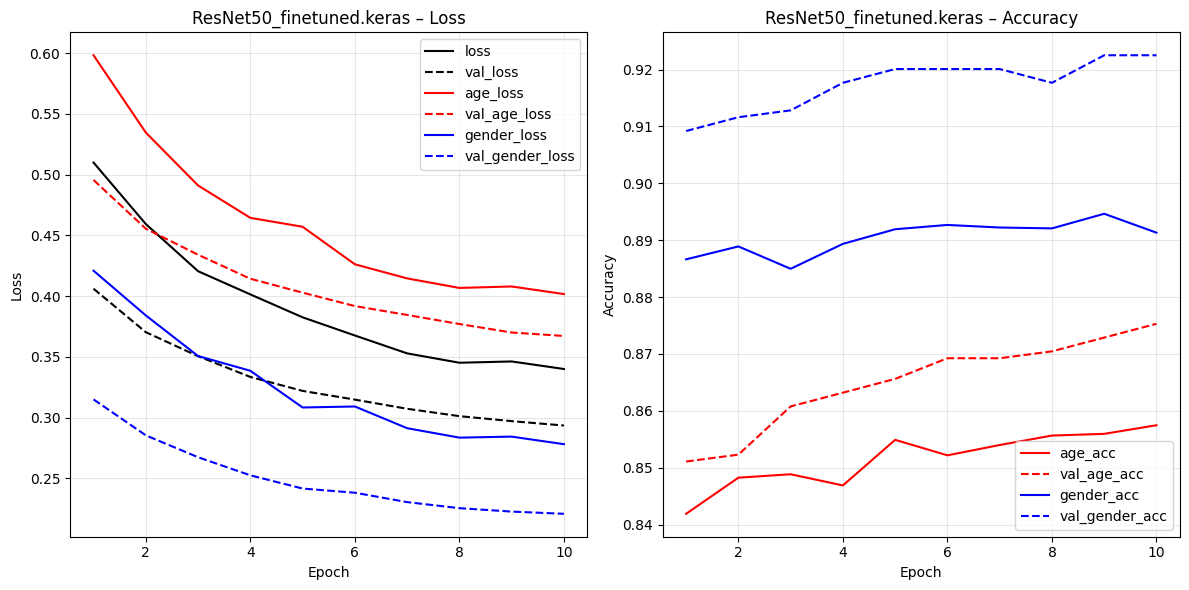

In [86]:
# Giả sử bạn fine-tune 5 epoch và lịch sử trả về là history_ft
plot_full_history(history, title='ResNet50_finetuned.keras')


In [83]:
# # lưu mô hình cuối
model.save(OUT_DIR / "ResNet50_finetuned.keras")

In [45]:
# train_full = train_aug.concatenate(add_aug(val_ds))

# FINAL_CALLBACKS = [
#     tf.keras.callbacks.EarlyStopping(patience=4,
#                                      restore_best_weights=True),
#     tf.keras.callbacks.ReduceLROnPlateau(patience=2,x
#                                          factor=0.3,
#                                          min_lr=1e-6)
# ]

# history_final = model.fit(
#     train_full,
#     epochs=30,           # sẽ dừng sớm
#     callbacks=FINAL_CALLBACKS,
#     verbose=2
# )
# # lưu mô hình cuối
# model.save(OUT_DIR / "EfficientNetB0_finetuned.keras")


Epoch 1/30
233/233 - 209s - 897ms/step - age_output_accuracy: 0.7106 - age_output_loss: 0.7597 - gender_output_accuracy: 0.7858 - gender_output_loss: 0.4479 - loss: 0.6039 - learning_rate: 1.0000e-05
Epoch 2/30


/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: age_output_accuracy,age_output_loss,gender_output_accuracy,gender_output_loss,loss
  current = self.get_monitor_value(logs)
/Users/admin/Library/Python/3.9/lib/python/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: age_output_accuracy,age_output_loss,gender_output_accuracy,gender_output_loss,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


233/233 - 215s - 923ms/step - age_output_accuracy: 0.7208 - age_output_loss: 0.7162 - gender_output_accuracy: 0.8061 - gender_output_loss: 0.4178 - loss: 0.5668 - learning_rate: 1.0000e-05
Epoch 3/30
233/233 - 232s - 994ms/step - age_output_accuracy: 0.7326 - age_output_loss: 0.6851 - gender_output_accuracy: 0.8056 - gender_output_loss: 0.4104 - loss: 0.5477 - learning_rate: 1.0000e-05
Epoch 4/30
233/233 - 229s - 984ms/step - age_output_accuracy: 0.7511 - age_output_loss: 0.6417 - gender_output_accuracy: 0.8112 - gender_output_loss: 0.3959 - loss: 0.5188 - learning_rate: 1.0000e-05
Epoch 5/30
233/233 - 223s - 958ms/step - age_output_accuracy: 0.7513 - age_output_loss: 0.6381 - gender_output_accuracy: 0.8234 - gender_output_loss: 0.3895 - loss: 0.5139 - learning_rate: 1.0000e-05
Epoch 6/30
233/233 - 205s - 881ms/step - age_output_accuracy: 0.7571 - age_output_loss: 0.6231 - gender_output_accuracy: 0.8241 - gender_output_loss: 0.3775 - loss: 0.5002 - learning_rate: 1.0000e-05
Epoch 7/30


In [106]:
def add_aug(ds):
    aug = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1)
    ])
    return ds.map(lambda x,y: (aug(x, training=True), y),
                  num_parallel_calls=tf.data.AUTOTUNE)


In [107]:
train_full = add_aug(train_ds).concatenate(add_aug(val_ds))

In [111]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-5),
    loss = {
        'age_output'   : tf.keras.losses.CategoricalCrossentropy(),   # ⚠️ đổi lại
        'gender_output': tf.keras.losses.BinaryCrossentropy()
    },
    loss_weights = {'age_output':0.5, 'gender_output':1.0},
    metrics = {'age_output':'accuracy', 'gender_output':'accuracy'}
)

In [25]:
import tensorflow as tf
from pathlib import Path

MODEL_PATH = Path("/Users/admin/Downloads/output/ResNet50_finetuned.keras")  # Correct file name

# Check if the file exists
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}")

# Load the model
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("Model loaded successfully.")

Model loaded successfully.


In [29]:
train_full = train_aug.concatenate(add_aug(val_ds))

FINAL_CALLBACKS = [
    tf.keras.callbacks.EarlyStopping(patience=4,
                                     restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2,
                                         factor=0.3,
                                         min_lr=1e-6)
]

history_final = model.fit(
    train_full,
    epochs=30,           # sẽ dừng sớm
    callbacks=FINAL_CALLBACKS,
    verbose=2
)
# lưu mô hình cuối
model.save(OUT_DIR / "Resnet50_final.keras")


Epoch 1/30


ValueError: y_true and y_pred have different structures.
y_true: *
y_pred: ['*', '*']


In [36]:
%pip install matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 1.4 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


2025-06-22 00:00:43.861829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


=== Gender branch ===
              precision    recall  f1-score   support

      Female       0.89      0.90      0.90       418
        Male       0.90      0.89      0.89       414

    accuracy                           0.89       832
   macro avg       0.89      0.89      0.89       832
weighted avg       0.89      0.89      0.89       832

=== Age branch ===
              precision    recall  f1-score   support

       Child       0.92      0.90      0.91       203
        Teen       0.94      0.83      0.89       212
       Adult       0.73      0.81      0.77       213
     Elderly       0.87      0.89      0.88       204

    accuracy                           0.86       832
   macro avg       0.87      0.86      0.86       832
weighted avg       0.87      0.86      0.86       832



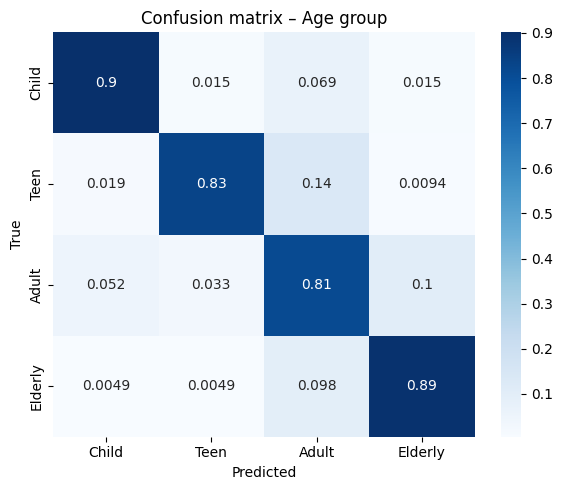

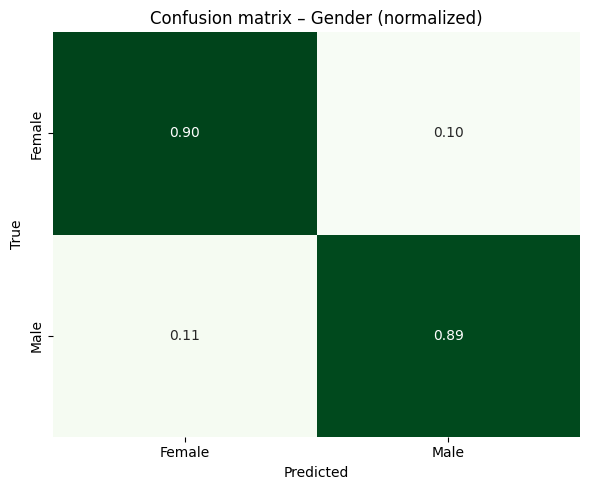

In [64]:
g_true, g_pred, a_true, a_pred = [], [], [], []

for imgs, lbl in test_ds:
    g_p, a_p = model.predict(imgs, verbose=0)
    g_true.extend(tf.argmax(lbl['gender_output'], axis=1).numpy())
    a_true.extend(tf.argmax(lbl['age_output'], axis=1).numpy())
    g_pred.extend(tf.argmax(g_p, axis=1).numpy())
    a_pred.extend(tf.argmax(a_p, axis=1).numpy())

print("=== Gender branch ===")
print(classification_report(g_true, g_pred, target_names=['Female','Male']))
print("=== Age branch ===")
print(classification_report(a_true, a_pred,
      target_names=['Child','Teen','Adult','Elderly']))

# Confusion matrix Age
cm = confusion_matrix(a_true, a_pred, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap='Blues',
            xticklabels=['Child','Teen','Adult','Elderly'],
            yticklabels=['Child','Teen','Adult','Elderly'])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion matrix – Age group")
plt.tight_layout()
plt.savefig(OUT_DIR / "cm_age.png", dpi=300)
plt.show()

cm_g = confusion_matrix(g_true, g_pred, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm_g, annot=True, cmap='Greens',
            xticklabels=['Female','Male'],
            yticklabels=['Female','Male'],
            fmt='.2f', cbar=False)
plt.title("Confusion matrix – Gender (normalized)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig("cm_gender.png", dpi=300)
plt.show()


In [67]:
from pathlib import Path
import json
import numpy as np

lat_ms = measure_latency(model)
size_mb = Path("models/ResNet50.keras").stat().st_size / 1e6  # Convert string to Path
params  = model.count_params() / 1e6

summary_json = {
    "Gender_acc_test": float(np.mean(np.array(g_true) == np.array(g_pred))),
    "Age_acc_test":    float(np.mean(np.array(a_true) == np.array(a_pred))),
    "Latency_ms":      lat_ms,
    "Model_size_MB":   size_mb,
    "Params_M":        params,
}
OUT_DIR = Path("output")  # Ensure OUT_DIR is defined as a Path object
OUT_DIR.mkdir(exist_ok=True)  # Create the directory if it doesn't exist
with open(OUT_DIR / "summary.json", "w") as f:
    json.dump(summary_json, f, indent=2)
print(summary_json)

{'Gender_acc_test': 0.8942307692307693, 'Age_acc_test': 0.859375, 'Latency_ms': 169.69366868336996, 'Model_size_MB': 240.121262, 'Params_M': 25.692038}


In [68]:
# Đã có cm_age.png; tiếp tục vẽ biểu đồ ROC hoặc PR nếu cần.
lat = summary_json["Latency_ms"]
acc = summary_json["Gender_acc_test"]
print(f"Latency: {lat:.1f} ms | Test Gender acc: {acc:.3f}")


Latency: 169.7 ms | Test Gender acc: 0.894


In [58]:
pip install mediapipe==0.10.9 tensorflow-macos tensorflow-metal


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 47.1 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 108 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 46.3 MB 44 kB/s  eta 0:00:01
     |████████████████████████████████| 63 kB 644 kB/s eta 0:00:01
     |████████████████████████████████| 162 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 227.0 MB 23 kB/s s eta 0:00:01   |█▋                              | 11.4 MB 222 kB/s eta 0:16:09     |███████▍                        | 52.7 MB 1.5 MB/s eta 0:01:55
     |████████████████████████████████| 14.0 MB 69 kB/s eta 0:00:011
     |████████████████████████████████| 5.5 MB 329 kB/s eta 0:00:01     |█████████████                   | 2.2 MB 227 kB/s eta 0:00:15
     |████████████████████████████████| 389 kB 544 kB/s eta 0:00:01
     |██████████████████████████████

In [12]:
pip uninstall -y protobuf mediapipe


Note: you may need to restart the kernel to use updated packages.


In [13]:
%pip install protobuf==3.20.3
%pip install mediapipe==0.10.9            # hoặc 0.9.3.1 nếu muốn wheel nhỏ


Defaulting to user installation because normal site-packages is not writeable
  Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached mediapipe-0.10.9-cp39-cp39-macosx_11_0_universal2.whl (47.1 MB)
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [14]:
import mediapipe as mp, google.protobuf as pb
print("MP:", mp.__version__, "| PB:", pb.__version__)
# → MP: 0.10.9 | PB: 3.20.3


/Users/admin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MP: 0.10.9 | PB: 3.20.3


**REALTIME TEST**


In [3]:
import cv2, time, numpy as np, tensorflow as tf, mediapipe as mp
from pathlib import Path
tf.keras.mixed_precision.set_global_policy("mixed_float16")

MODEL_PATH = Path("exp_outputs/EfficientNetB0_finetuned.keras")
AGE_LABELS, GENDER_LABELS = ['Child','Teen','Adult','Elderly'], ['Female','Male']
FONT, IMG_SIZE = cv2.FONT_HERSHEY_SIMPLEX, (224,224)

print("[INFO] loading model …")
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

mp_face = mp.solutions.face_detection
detector = mp_face.FaceDetection(model_selection=0,  # 0 = short-range
                                 min_detection_confidence=0.6)

def preprocess(frame, rel):
    h,w,_ = frame.shape
    x0,y0,x1,y1 = int(rel.xmin*w), int(rel.ymin*h), int((rel.xmin+rel.width)*w), int((rel.ymin+rel.height)*h)
    face = frame[max(0,y0):y1, max(0,x0):x1]
    if face.size==0: return None,(x0,y0,x1,y1)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, IMG_SIZE)
    face = tf.keras.applications.efficientnet.preprocess_input(face)
    return face,(x0,y0,x1,y1)

def predict(arr):
    g, a = model(arr[None,...], training=False)
    return GENDER_LABELS[int(tf.argmax(g[0]))], AGE_LABELS[int(tf.argmax(a[0]))]

cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)
cap.set(cv2.CAP_PROP_FRAME_WIDTH,640); cap.set(cv2.CAP_PROP_FRAME_HEIGHT,360)
if not cap.isOpened(): raise RuntimeError("Mở camera không thành công.")

fps, t0, n = 0, time.time(), 0
print("[INFO] press  q  to quit")
while True:
    ok, frame = cap.read()
    if not ok: break
    res = detector.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if res.detections:
        for det in res.detections:
            face, box = preprocess(frame, det.location_data.relative_bounding_box)
            if face is None: continue
            gender, age = predict(face)
            x0,y0,x1,y1 = box
            col = (0,255,0) if gender=="Male" else (147,20,255)
            cv2.rectangle(frame,(x0,y0),(x1,y1),col,2)
            label = f"{gender}, {age}"
            (tw,th),_ = cv2.getTextSize(label,FONT,0.6,2)
            cv2.rectangle(frame,(x0,y0-th-8),(x0+tw+4,y0),col,-1)
            cv2.putText(frame,label,(x0+2,y0-4),FONT,0.6,(255,255,255),1)

    n+=1
    if n==30: fps,t0,n = 30/(time.time()-t0),time.time(),0
    cv2.putText(frame,f"FPS:{fps:.1f}",(10,25),FONT,0.7,(0,255,255),2)
    cv2.imshow("Realtime Gender & Age",frame)
    if cv2.waitKey(1)&0xFF==ord('q'): break

cap.release(); cv2.destroyAllWindows()


[INFO] loading model …


2025-06-24 14:52:02.627808: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-24 14:52:02.628003: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-24 14:52:02.628009: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-24 14:52:02.628402: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-24 14:52:02.628426: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
I0000 00:00:1750751525.704874       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
OpenCV: not authori

RuntimeError: Mở camera không thành công.

In [96]:
import cv2, time, numpy as np, tensorflow as tf, mediapipe as mp
from pathlib import Path
tf.keras.mixed_precision.set_global_policy("mixed_float16")

MODEL_PATH = Path("/Users/admin/Downloads/output/ResNet50_finetuned.keras")
AGE_LABELS, GENDER_LABELS = ['Child','Teen','Adult','Elderly'], ['Female','Male']
FONT, IMG_SIZE = cv2.FONT_HERSHEY_SIMPLEX, (224,224)

print("[INFO] loading model …")
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

mp_face = mp.solutions.face_detection
detector = mp_face.FaceDetection(model_selection=0,  # 0 = short-range
                                 min_detection_confidence=0.6)

def preprocess(frame, rel):
    h,w,_ = frame.shape
    x0,y0,x1,y1 = int(rel.xmin*w), int(rel.ymin*h), int((rel.xmin+rel.width)*w), int((rel.ymin+rel.height)*h)
    face = frame[max(0,y0):y1, max(0,x0):x1]
    if face.size==0: return None,(x0,y0,x1,y1)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, IMG_SIZE)
    face = tf.keras.applications.efficientnet.preprocess_input(face)
    return face,(x0,y0,x1,y1)

def predict(arr):
    g, a = model(arr[None,...], training=False)
    return GENDER_LABELS[int(tf.argmax(g[0]))], AGE_LABELS[int(tf.argmax(a[0]))]

cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)
cap.set(cv2.CAP_PROP_FRAME_WIDTH,640); cap.set(cv2.CAP_PROP_FRAME_HEIGHT,360)
if not cap.isOpened(): raise RuntimeError("Mở camera không thành công.")

fps, t0, n = 0, time.time(), 0
print("[INFO] press  q  to quit")
while True:
    ok, frame = cap.read()
    if not ok: break
    res = detector.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if res.detections:
        for det in res.detections:
            face, box = preprocess(frame, det.location_data.relative_bounding_box)
            if face is None: continue
            gender, age = predict(face)
            x0,y0,x1,y1 = box
            col = (0,255,0) if gender=="Male" else (147,20,255)
            cv2.rectangle(frame,(x0,y0),(x1,y1),col,2)
            label = f"{gender}, {age}"
            (tw,th),_ = cv2.getTextSize(label,FONT,0.6,2)
            cv2.rectangle(frame,(x0,y0-th-8),(x0+tw+4,y0),col,-1)
            cv2.putText(frame,label,(x0+2,y0-4),FONT,0.6,(255,255,255),1)

    n+=1
    if n==30: fps,t0,n = 30/(time.time()-t0),time.time(),0
    cv2.putText(frame,f"FPS:{fps:.1f}",(10,25),FONT,0.7,(0,255,255),2)
    cv2.imshow("Realtime Gender & Age",frame)
    if cv2.waitKey(1)&0xFF==ord('q'): break

cap.release(); cv2.destroyAllWindows()


[INFO] loading model …


I0000 00:00:1750532149.235597       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M1


[INFO] press  q  to quit


In [23]:
import cv2
for idx in range(4):
    cap = cv2.VideoCapture(idx, cv2.CAP_AVFOUNDATION)
    print(idx, cap.isOpened())
    cap.release()


0 True
1 False
2 False
3 False


OpenCV: out device of bound (0-0): 1
OpenCV: camera failed to properly initialize!
[ WARN:0@2258.861] global cap.cpp:480 open VIDEOIO(AVFOUNDATION): backend is generally available but can't be used to capture by index
OpenCV: out device of bound (0-0): 2
OpenCV: camera failed to properly initialize!
[ WARN:0@2258.884] global cap.cpp:480 open VIDEOIO(AVFOUNDATION): backend is generally available but can't be used to capture by index
OpenCV: out device of bound (0-0): 3
OpenCV: camera failed to properly initialize!
[ WARN:0@2258.906] global cap.cpp:480 open VIDEOIO(AVFOUNDATION): backend is generally available but can't be used to capture by index


In [24]:
import cv2

def open_cam(index=0):
    cap = cv2.VideoCapture(index)              # backend mặc định
    if not cap.isOpened():
        cap = cv2.VideoCapture(index, cv2.CAP_AVFOUNDATION)
    if not cap.isOpened():
        raise RuntimeError("Không mở được camera – kiểm tra quyền & ứng dụng đang chiếm.")
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 360)
    return cap

cap = open_cam(0)


In [62]:
%pip brew install opencv

ERROR: unknown command "brew"
Note: you may need to restart the kernel to use updated packages.


In [64]:
model.save(OUT_DIR / "EfficientNetB0_finetuned.keras")
# OUT_DIR = Path("exp_outputs")
